<center>
<img src="https://2223moodle.isel.pt/pluginfile.php/1/theme_adaptable/logo/1631635830/logo-isel_inv3.png" width="250">
<h3>Licenciatura em Engenharia Informática e Multimédia</h3><br>
Ano Letivo 2023/2024<br>
<h3>Aprendizagem Automática (AA)</h3>
<h3>Projeto Final - Rate Beer Dataset</h3> 


<center> 
<br>
Ricardo Vieira <b>A45871</b><br>
Eduardo Marques <b>A45977</b><br>
Turma 52D<br><br>
Docente: Engenheiro Gonçalo Xufre<br> 
21 de Janeiro 2024
</center>
</center>

***
<br>
<a id='section0'></a>
<center><h2><b>Índice</b></h2></center>

- [Introdução](#section1)
- [Conceitos Teóricos](#section2)
- [Procedimento](#section3)
- [Funções Auxiliares](#section4)
- [Desenvolvimento](#section5)
- [Classificador 1: Regressão Logística](#section6)
- [Classificador 2: SVM - Support Vector Machine](#section7)
- [Classificador 3: Multinomial Naive Bayes](#section8)
- [Comparação de Resultados](#section9)

In [1]:
# Lista de imports
import cv2 
import itertools
import nltk
import pandas
import pickle
import re
import sklearn
import time
import os

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from itertools import product

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

<a id='section1'></a>
# <center><br><b>Introdução</b></center>
Como projeto final da Unidade Curricular de Aprendizagem Automática, foi-nos proposto um problema de classificação que tem como objetivo determinar a qualidade de uma cerveja através dos comentários acerca desta. As duas tarefas de classificação pedidas no enunciado são as seguintes:
- **Classificação Binária:** Nesta tarefa, pretende-se saber se o crítico considera a cerveja muito boa ou muito má, através do comentário. Uma cerveja é considerada muito boa quando obteve uma pontuação global de 9 ou mais valores. Pelo contrário, uma cerveja é considerada muito má quando pontuação global é de 2 ou menos valores.
- **Classificação Multiclasse:** Esta tarefa serve para prever a pontuacão de três aspetos das críticas (smell, taste e overall). Neste ponto, são treinados e avaliados os classificadores com os dados de treino e é feita a comparação do desempenho em relação aos dados de teste.

Para isso foram fornecidos dois ficheiros <i>pickle</i>: <b>rateBeer75Ktrain.p</b> para treino, com 75000 críticas de cerveja, e <b>rateBeer25Ktest.p</b> para teste com 25000 críticas. É com estes dados, que foram recolhidos ao longo de um período de dez anos, que vamos trabalhar e explicar cada passo efetuado.

<a id='section2'></a>
# <center><br><br><b>Conceitos Teóricos</b></center>
<a id='section2-1'></a>
Antes de partirmos para a parte prática que envolve o código realizado, temos de ter presentes alguns conceitos teóricos que são naturalmente muito importantes para a realização do trabalho de modo a entendermos melhor o que nos é pedido, e aquilo em que consiste cada passo. Abaixo são enumerados alguns destes temas com uma breve explicação teórica e de que forma podem ser abordados no trabalho prático.

## Pré-Processamento 
Este é o primeiro passo a ser efetuado assim que extraímos os dados e vai ser extremamente importante neste trabalho como iremos ver de seguida. Tem como objetivo "limpar" os dados extraídos e transformá-los no tipo de dados que estamos à espera, de acordo com aquilo que se pretende.<br>
Este passo de pré-processamento é necessário uma vez que estamos a tratar uma enorme quantidade de dados que foram retirados de um site de criticas, onde não podemos controlar aquilo que cada pessoa escreve. Por isso, antes de usarmos estes dados nos passos seguintes, podemos convertê-los para um formato adequado, de forma a que seja mais fácil para a máquina de os processar, evitando ao mesmo tempo potenciais erros.<br>
Como não queremos ter um vocabulário demasiado extenso e com palavras desnecessárias, os dados serão "limpos" da mesma forma para todos os ficheiros, garantindo desta forma que mantemos o padrão e que guardamos apenas as palavras que mais nos interessam.
<br><br>
<a id='section2-2'></a>
## Aprendizagem Supervisionada 
Este tipo de aprendizagem, tal como o nome sugere, tem um "supervisor" e é usada para "ensinar" a máquina através de dados que já foram classificados. Por isso, quando for classificar os novos dados, vai comparar as características novas com aquelas que foram retiradas dos dados fornecidos anteriormente, de forma a associar os dados às classes adequadas.<br>
Tem o lado positivo de permitir optimizar o critério de decisão com base na experiência passada, solucionando muitos problemas do mundo real. Por outro lado, a classificação de dados de larga escala pode ser um desafio, precisando de muito tempo e carga computacional.<br>
A principal vantagem deste método é a capacidade de otimizar o critério de decisão com base na experiência passada, proporcionando soluções mais eficientes para diversos problemas do mundo real. No entanto, e apesar dos seus benefícios, é importante mencionar que a qualidade e representatividade dos dados de treino têm um papel crucial no desempenho do modelo. Além disso, o processo de treino é mais puxado em termos de recursos computacionais, especialmente quando lida com conjuntos de dados extensos e complexos.
<br><br><br>
## Aprendizagem não Supervisionada 
Por outro lado, a aprendizagem não supervisionada opera sem um "supervisor" e a sua principal função é analisar informações sem ter sido previamente instruída. Consiste em agrupar dados com base em semelhanças, padrões e diferenças, sem a necessidade de ter acesso prévio a conjuntos de dados. A aprendizagem não supervisionada destina-se a fazer descobertas autônomas e alguns exemplos de técnicas incluem o <b>Clustering</b> e a <b>Associação</b>. É por isso particularmente útil em cenários onde a estrutura dos dados é desconhecida ou não categorizada previamente.
<br><br>
Neste trabalho, estamos perante um caso de classificação sendo essa a Regressão Logistica.<b>Supervisionada</b>

<a id='section3'></a>
# <center><br><b>Procedimento</b></center>
Importa começar por explicar a estrutura que será seguida na implementação:\
\
-1. Preparação de dados: Preparam-se funções e dados para o processo de vectorizer.

-2. Calibração de Classificadores e tfidf Vectorizer: Vão ser procurados os melhores valores para a frequencia e padrão de tokens.

-3. Análise Individual dos Resultados de cada Classificador

-4. Comparação de Classificadores

<a id='section4'/></a>
# <center><br><br><b>Funções auxiliares</b></center>

## Funções e Variáveis Auxiliares
Nesta secção, apresenta-se uma série de funções auxiliares que serão úteis ao longo do trabalho. A descrição de cada função vem comentada acima de cada método

In [2]:
# Recebe o nome de um ficheiro que contenha informação a ser lida como pickle.
def openFile(filename):
    return pickle.load(open(filename, 'rb'))

# Escreve um ficheiro com informação em formato pickle.
def dump_to_pickle(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

# Recebe um array com um ou mais documentos, limpando-os de forma a conter apenas em caracteres alfabéticos sem acentos.
# Flag binary, por omissão a 0, indica a necessidade de descodificação binária
def cleanFile(documentos, binary=False):
    #Converte strings binárias para strings normais
    if binary:
        documentos = [doc.decode('UTF-8') for doc in documentos]
        
    #Remove marcas html de mudança de linha
    documentos = [doc.replace('<br />', ' ') for doc in documentos]
    
    #Elimina todos os caracteres que não sejam alfabéticos
    documentos = [re.sub('[^a-zA-Z0-9\u00C0-\u00FF/]' , ' ', doc) for doc in documentos]
    
    return documentos

<a id='section5'/></a>
# <center><br><br><b>Desenvolvimento</b></center>


<a id='section5-1'/></a>
## <center><br><br><b>Estudo dos dados</b></center>



In [3]:
D_train = openFile('rateBeer75Ktrain.p')
D_test = openFile('rateBeer25Ktest.p')

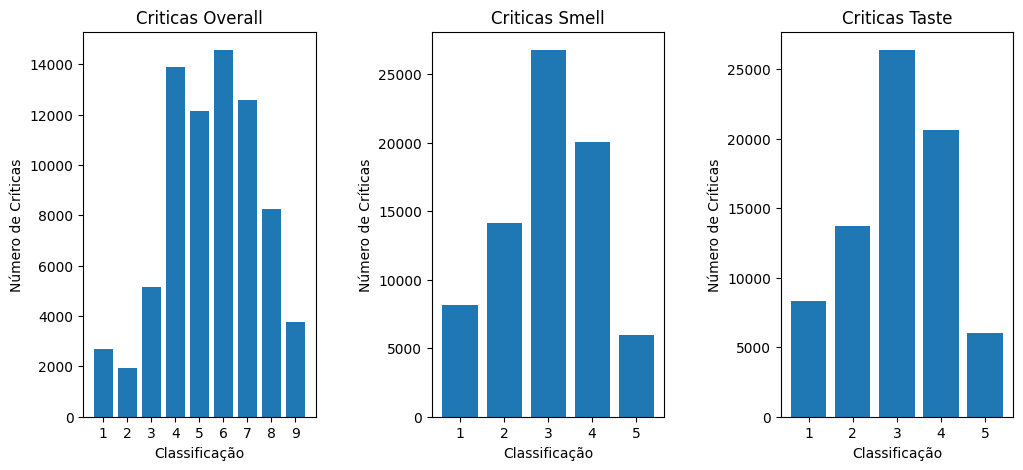

In [4]:
# X de treino
X1 = np.array([value["review"] for value in D_train.values()])
# y de treino
y1Smell = np.array([value["smell"][0] for value in D_train.values()])
y1Taste = np.array([value["taste"][0] for value in D_train.values()])
y1Overall = np.array([value["overall"][0] for value in D_train.values()])

# X de teste
X2 = np.array([value["review"] for value in D_test.values()])
# y de teste
y2Smell = np.array([value["smell"][0] for value in D_test.values()])
y2Taste = np.array([value["taste"][0] for value in D_test.values()])
y2Overall = np.array([value["overall"][0] for value in D_test.values()])

labels_overall, counts_overall = np.unique(y1Overall, return_counts=True)
labels_smell, counts_smell = np.unique(y1Smell, return_counts=True)
labels_taste, counts_taste = np.unique(y1Taste, return_counts=True)

# Criação dos subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Subplot 1
axs[0].set_title('Criticas Overall')
axs[0].bar(labels_overall, counts_overall, align='center')
axs[0].set_xticks(np.arange(0, 9, step=1))
axs[0].set_ylabel('Número de Críticas')
axs[0].set_xlabel('Classificação')

# Subplot 2
axs[1].set_title('Criticas Smell')
axs[1].bar(labels_smell, counts_smell, align='center')
axs[1].set_xticks(np.arange(0, 5, step=1))
axs[1].set_ylabel('Número de Críticas')
axs[1].set_xlabel('Classificação')

# Subplot 3
axs[2].set_title('Criticas Taste')
axs[2].bar(labels_taste, counts_taste, align='center')
axs[2].set_xticks(np.arange(0, 5, step=1))
axs[2].set_ylabel('Número de Críticas')
axs[2].set_xlabel('Classificação')

# Ajusta o espaçamento entre os subplots
plt.subplots_adjust(wspace=0.5)

# Mostra o gráfico
plt.show()

Para já começamos apenas por estudar os dados fornecidos, construindo o gráfico de barras acima para podermos observar melhor a distribuição dos dados de treino. Como era esperado, a classificação varia entre 1 e 9 e a grande maioria dos dados está concentrada nas classificações centrais, entre 4 e 7. Isto é um fator importante a considerar, principalmente para a <b>Classificação Binária</b> onde vamos apenas considerar as classificações muito más (2 ou menos) e muito boas (8 ou mais).\
No entanto, antes de passarmos à classificação, é necessário tratarmos da limpeza dos dados, como vimos anteriormente na definição de pré-processamento e da sua importância.

<a id='section5-2'/></a>
## <center><br><br><b>Pré-Processamento dos dados</b></center>

Nesta secção vamos começar por testar o método <i><b>cleanFile</b></i> que foi implementado no começo. Tal como o nome indica, o seu objetivo é limpar o texto recebido, de forma a que este esteja no formato correto para ser usado mais tarde pelo classificador. Este método converte strings binárias para strings normais, remove marcas HTML de mudança de linha, e ainda elimina todos os caracteres que não sejam alfabéticos ou acentuados.
Para testar a função escolhemos uma critica e mostramos o seu conteúdo antes e após a limpeza dos dados.

<a id='section2-2-1'/></a>
## Método cleanFile()

In [72]:
print('Crítica Conforme Lida: \n', X1[104])
print()
Docs_train = cleanFile(X1)
print('Crítica Após Limpeza: \n', X1[104])

Docs_test = cleanFile(X2)

Crítica Conforme Lida: 
 22 oz. bottle from Plaza Liquors - Pours a clear golden color with a one finger thick off white head.  Nice lacing.  Aroma is floral and citrus hops.  Flavor is much of the same with some nice malt sweetness.  The hops linger in the finish.  Medium to full body.  A nice beer.

Crítica Após Limpeza: 
 22 oz. bottle from Plaza Liquors - Pours a clear golden color with a one finger thick off white head.  Nice lacing.  Aroma is floral and citrus hops.  Flavor is much of the same with some nice malt sweetness.  The hops linger in the finish.  Medium to full body.  A nice beer.


<a id='section5-2-2'/></a>
## Stemming

Além de aplicarmos esta função vamos também ter um processo de stemming, que faz parte ainda do pré-processamento do texto e envolve a redução das palavras para as suas formas mais básicas, removendo sufixos e prefixos. O objetivo é simplificar as palavras ao máximo para que diferentes formas da mesma palavra sejam efetivamente convetidas na mesma, e possam ser classificadas como tal. Além disso ajuda também a reduzir a dimesão do texto e melhorar a eficiência na sua análise.

O processo de stemming pode ser realizado por diferentes algoritmos, tais como:

- <b>Porter Stemmer</b>: É o algoritmo clássico de stemming, utiliza um conjunto de regras para reduzir palavras à sua forma básica. 

- <b>Snowball Stemmer</b>: É uma versão melhorada do Porter Stemmer, desenvolvida para ser mais "agressiva" na redução das palavras.

- <b>Lancaster Stemmer</b>: Outro algoritmo de stemming, também mais agressivo que o Porter Stemmer, resultando em palavras ainda mais curtas.

In [6]:
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer


# Stemming das criticas
"""
porterStemFunc = PorterStemmer()
Docs_train_PorterStem = [' '.join([porterStemFunc.stem(word) for word in doc.split()]) for doc in Docs_train]
pickle.dump(Docs_train_PorterStem, open('docs_train_PorterStem.p', 'wb'))
Docs_test_PorterStem = [' '.join([porterStemFunc.stem(word) for word in doc.split()]) for doc in Docs_test]
pickle.dump(Docs_test_PorterStem, open('docs_test_PorterStem.p', 'wb'))

snowballSteamFunc = SnowballStemmer('english')
Docs_train_SnowballStem = [' '.join([snowballSteamFunc.stem(word) for word in doc.split()]) for doc in Docs_train]
pickle.dump(Docs_train_SnowballStem, open('docs_train_SnowballStem.p', 'wb'))
Docs_test_SnowballStem = [' '.join([snowballSteamFunc.stem(word) for word in doc.split()]) for doc in Docs_test]
pickle.dump(Docs_test_SnowballStem, open('docs_test_SnowballStem.p', 'wb'))

lancasterStemFunc = LancasterStemmer()
Docs_train_LancasterStem = [' '.join([lancasterStemFunc.stem(word) for word in doc.split()]) for doc in Docs_train]
pickle.dump(Docs_train_LancasterStem, open('docs_train_LancasterStem.p', 'wb'))
Docs_test_LancasterStem = [' '.join([lancasterStemFunc.stem(word) for word in doc.split()]) for doc in Docs_test]
pickle.dump(Docs_test_LancasterStem, open('docs_test_LancasterStem.p', 'wb'))"""

"\nporterStemFunc = PorterStemmer()\nDocs_train_PorterStem = [' '.join([porterStemFunc.stem(word) for word in doc.split()]) for doc in Docs_train]\npickle.dump(Docs_train_PorterStem, open('docs_train_PorterStem.p', 'wb'))\nDocs_test_PorterStem = [' '.join([porterStemFunc.stem(word) for word in doc.split()]) for doc in Docs_test]\npickle.dump(Docs_test_PorterStem, open('docs_test_PorterStem.p', 'wb'))\n\nsnowballSteamFunc = SnowballStemmer('english')\nDocs_train_SnowballStem = [' '.join([snowballSteamFunc.stem(word) for word in doc.split()]) for doc in Docs_train]\npickle.dump(Docs_train_SnowballStem, open('docs_train_SnowballStem.p', 'wb'))\nDocs_test_SnowballStem = [' '.join([snowballSteamFunc.stem(word) for word in doc.split()]) for doc in Docs_test]\npickle.dump(Docs_test_SnowballStem, open('docs_test_SnowballStem.p', 'wb'))\n\nlancasterStemFunc = LancasterStemmer()\nDocs_train_LancasterStem = [' '.join([lancasterStemFunc.stem(word) for word in doc.split()]) for doc in Docs_train]\n

In [7]:
X_train_PorterStem = openFile('docs_train_PorterStem.p')
X_test_PorterStem = openFile('docs_test_PorterStem.p')
X_train_SnowballStem = openFile('docs_train_SnowballStem.p')
X_train_LancasterStem = openFile('docs_train_LancasterStem.p')

print('Crítica antes de Stemming: \n', X1[1])
print()
print('Crítica após PorterStem: \n',X_train_PorterStem[1])
print()
print('Crítica após SnowballStem: \n',X_train_SnowballStem[1])
print()
print('Crítica após LancasterStem: \n',X_train_LancasterStem[1])

Crítica antes de Stemming: 
 Compliments of a trade with goldtwins, thanks!	Poured dark with very little head.  Coffee bean and chocolate dominate from the start, slight sweetness in the middle and finishes with a bit of bitterness from the coffee.  A nice hefty porter for the winter months.

Crítica após PorterStem: 
 compliment of a trade with goldtwin thank pour dark with veri littl head coffe bean and chocol domin from the start slight sweet in the middl and finish with a bit of bitter from the coffe a nice hefti porter for the winter month

Crítica após SnowballStem: 
 compliment of a trade with goldtwin thank pour dark with veri littl head coffe bean and chocol domin from the start slight sweet in the middl and finish with a bit of bitter from the coffe a nice hefti porter for the winter month

Crítica após LancasterStem: 
 comply of a trad with goldtwin thank pour dark with very littl head coff bean and chocol domin from the start slight sweet in the middl and fin with a bit of 

Como podemos ver, e tal como era esperado, muitas das palavras são reduzidas para formas mais básicas ou curtas da mesma palavra, com o objetivo de reduzirmos ao máximo a dimensão do vocabulário.

<a id='section5-2-3'/></a>
## Vetorização

O último passo do pré-processamento é a vetorização, onde temos de entender alguns conceitos:

- <b>TF-IDF</b> (Term Frequency-Inverse Document Frequency):
TF-IDF é uma forma de avaliar a importância de uma palavra num conjunto de textos. Considera duas coisas:

- <b>Frequência da palavra no Texto (TF)</b>: Se uma palavra aparece muitas vezes no texto, tem um TF alto para esse texto.

- <b>Raridade da palavra é no Conjunto (IDF)</b>: Se uma palavra é rara em todo o conjunto de textos, tem um IDF alto.

O valor final de TF-IDF é uma combinação dessas duas medidas. Palavras com pontuações TF-IDF mais altas são consideradas mais importantes e específicas para um texto, que é algo que devemos ter em consideração ao analisar as críticas.

Existem ainda dois parâmetros importantes: <b>min_df</b> que define a quantidade mínima de vezes que uma palavra deve aparecer para ser incluída e <b>token_pattern</b> que define o padrão que uma palavra deve seguir para ser considerada.

Além disso, queremos remover todas as <b>Stop Words</b> que encontrarmos. Isto são as palavras mais comuns como por exemplo "e", "ou", "o" e que não contribuem muito para o vocabulário. Ao removermos as Stop Words estamos apenas a focar-nos nas palavras mais importantes.

Vamos então testar diferentes configurações para o modelo TF-IDF, criando combinações de valores para os parâmetros min_df e token_pattern. 

In [8]:
def process_tfidf_vectorizer(Docs, _min_df = 1,_token_pattern = r"\b\w\w\w+\b", _stop_words = "english", _ngram_range = (1,1)):
    tfidf=TfidfVectorizer(min_df=_min_df, token_pattern=_token_pattern, stop_words=_stop_words, ngram_range=_ngram_range).fit(Docs)
    tokens=tfidf.get_feature_names_out()
    
    return tfidf, tokens

In [9]:
"""dfs = [1,2,3]
tps = [r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b']
combos = [(df,tp) for df in dfs for tp in tps]

# Obtenção dos modelos tf-idf
resultadosSemStop = [len(TfidfVectorizer(min_df=df, token_pattern=tp).fit(X_train_PorterStem).get_feature_names_out()) for (df, tp) in combos]
resultadosComStop = [len(TfidfVectorizer(min_df=df, stop_words="english", token_pattern=tp).fit(X_train_PorterStem).get_feature_names_out()) for (df, tp) in combos]

# Escrita dos resultados num ficheiro
pickle.dump({'resultados' : np.array(resultadosSemStop).reshape((3,3))}, open('numero_palavras_sem_stop.p', 'wb'))
pickle.dump({'resultados' : np.array(resultadosComStop).reshape((3,3))}, open('numero_palavras_com_stop.p', 'wb'))"""

'dfs = [1,2,3]\ntps = [r\'\x08\\w\\w+\x08\', r\'\x08\\w\\w\\w+\x08\', r\'\x08\\w\\w\\w\\w+\x08\']\ncombos = [(df,tp) for df in dfs for tp in tps]\n\n# Obtenção dos modelos tf-idf\nresultadosSemStop = [len(TfidfVectorizer(min_df=df, token_pattern=tp).fit(X_train_PorterStem).get_feature_names_out()) for (df, tp) in combos]\nresultadosComStop = [len(TfidfVectorizer(min_df=df, stop_words="english", token_pattern=tp).fit(X_train_PorterStem).get_feature_names_out()) for (df, tp) in combos]\n\n# Escrita dos resultados num ficheiro\npickle.dump({\'resultados\' : np.array(resultadosSemStop).reshape((3,3))}, open(\'numero_palavras_sem_stop.p\', \'wb\'))\npickle.dump({\'resultados\' : np.array(resultadosComStop).reshape((3,3))}, open(\'numero_palavras_com_stop.p\', \'wb\'))'

In [10]:
resultados1 = pickle.load(open('numero_palavras_sem_stop.p', 'rb'))['resultados']
resultados2 = pickle.load(open('numero_palavras_com_stop.p', 'rb'))['resultados']
print(resultados1)
print()
print(resultados2)

[[44018 43384 40899]
 [21789 21275 19775]
 [16458 16002 14842]]

[[43792 43188 40744]
 [21572 21088 19629]
 [16244 15818 14698]]


Podemos verificar que não existe uma diferença significativa entre as frases com stop words e sem stop words. Com esta informação iremos utilizar as reviews sem stop words, visto que é uma pouca diferença.

À medida que aumentamos a exigência da frequência mínima (min_df), o vocabulário torna-se mais restrito, contendo apenas palavras que aparecem com maior frequência nos documentos, excluindo as palavras menos frequentes. Podemos ainda observar que esta diferença é maior para valores mais baixos de frequência miníma, o que indica que há várias palavras que só aparecem uma ou duas vezes.

Entre tps podemos verificar que a diferença não é muito acentuada pelo que iremos usar a expressão "r'\b\w\w\w+\b'"

Serão usados os parêmetros min_dif = 1 e token_pattern = r'\b\w\w\w+\b' e stop_words="english".

## Limpeza

In [11]:
teste_antes_limpar = TfidfVectorizer(min_df=1, stop_words="english", token_pattern=r'\b\w\w\w\w+\b').fit(X_train_PorterStem).get_feature_names_out()
print("Tokens sem stop words: ", teste_antes_limpar[:10])

Tokens sem stop words:  ['00000000000' '00007738' '0001' '000th' '0013' '001880' '0019'
 '00802a1ba' '00am' '010308']


Verificamos que ainda existem muitas palavras sem significado, pelo que teremos que as retirar antes de efetual a vetorização.

In [12]:
Docs_train_aux = [re.sub(r'[^a-zA-Z]', ' ', doc) for doc in X_train_PorterStem]
teste_depois_limpar = TfidfVectorizer(min_df=1, stop_words="english", token_pattern=r'\b\w\w\w\w+\b').fit(Docs_train_aux).get_feature_names_out()
print("Tokens sem stop words: ", teste_depois_limpar[:10])

print("Diferença do número de palavras: ", len(teste_antes_limpar) - len(teste_depois_limpar))

Tokens sem stop words:  ['aaaaa' 'aaaaaaahhhh' 'aaaaaaight' 'aaaaaeeeeieee' 'aaaaah' 'aaaah'
 'aaaahhahahahahhaaaaaaaa' 'aaaahhhhh' 'aaaanyway' 'aaahhh']
Diferença do número de palavras:  2238


Podemos verificar que continuam a existir palavras sem significado, mas já não exitem palavras com numeros, que era o objetivo. Verificamos ainda que houve uma diminuição de mais de 2000 palavras do vocabulário.

## Tratamento das reviews de treino e teste

In [13]:
Docs_train_aux = [re.sub(r'[^a-zA-Z]', ' ', doc) for doc in X_train_PorterStem]
Docs_test_aux = [re.sub(r'[^a-zA-Z]', ' ', doc) for doc in X_test_PorterStem]

tfidf, train_tokens = process_tfidf_vectorizer(X_train_PorterStem)
X_test = tfidf.transform(Docs_test_aux)
X_train = tfidf.transform(Docs_train_aux)

# Classificação Binária

Na classificação binária é pretendido saber se um crítico considera uma cerveja muito boa ou muito má baseado no que escreveu. Para tal, uma cerveja é considerada muito boa quando se obtem uma pontuação global maior ou igual a 9 e muito má quando a pontuação global é menor ou igual a 2.

Vamos começar então por efetuar a divisão dos conjuntos de treino e teste em dois conjuntos cada, um conjunto "positivo" e um "negativo"

In [14]:
y1Overall_aux = y1Overall.copy()
y2Overall_aux = y2Overall.copy()

print(y1Overall_aux.size)
print(y2Overall_aux.size)

y1_muito_bom = []
y1_muito_mau = []

y2_muito_bom = []
y2_muito_mau = []

for i in y1Overall_aux:
    if i < '3':
        y1_muito_mau.append(1)
        y1_muito_bom.append(0)
    elif i >= '9':
        y1_muito_bom.append(1)
        y1_muito_mau.append(0)
    else:
        y1_muito_bom.append(0)
        y1_muito_mau.append(0)
        
for i in y2Overall_aux:
    if i < '3':
        y2_muito_mau.append(1)
        y2_muito_bom.append(0)
    elif i >= '9':
        y2_muito_bom.append(1)
        y2_muito_mau.append(0)
    else:
        y2_muito_bom.append(0)
        y2_muito_mau.append(0)

75000
25000


<a id='section6'/></a>
# Classificador 1: Regressão logistica

### Quais os melhores parâmetros

In [15]:
"""C_test = [0.1, 1, 10, 100]
max_iter_test = [100, 1000, 10000]
tol_test = [0.0001, 0.001, 0.01, 0.1]

param_combinations = product(C_test, max_iter_test, tol_test)

melhores_vals = 0
melhores_params = []

for C_test, max_iter_test, tol_test in param_combinations:
    dl_bom = LogisticRegression(penalty='l2', max_iter=max_iter_test, C=C_test, tol=tol_test)
    dl_bom.fit(X_train, y1_muito_bom)
    testing_score = dl_bom.score(X_train, y1_muito_bom)
    if testing_score > melhores_vals:
        melhores_vals = testing_score
        melhores_params = [C_test, max_iter_test, tol_test]

dump_to_pickle(melhores_vals, 'melhores_vals_logistic_regression.p')
dump_to_pickle(melhores_params, 'melhores_params_logistic_regression.p')"""

"C_test = [0.1, 1, 10, 100]\nmax_iter_test = [100, 1000, 10000]\ntol_test = [0.0001, 0.001, 0.01, 0.1]\n\nparam_combinations = product(C_test, max_iter_test, tol_test)\n\nmelhores_vals = 0\nmelhores_params = []\n\nfor C_test, max_iter_test, tol_test in param_combinations:\n    dl_bom = LogisticRegression(penalty='l2', max_iter=max_iter_test, C=C_test, tol=tol_test)\n    dl_bom.fit(X_train, y1_muito_bom)\n    testing_score = dl_bom.score(X_train, y1_muito_bom)\n    if testing_score > melhores_vals:\n        melhores_vals = testing_score\n        melhores_params = [C_test, max_iter_test, tol_test]\n\ndump_to_pickle(melhores_vals, 'melhores_vals_logistic_regression.p')\ndump_to_pickle(melhores_params, 'melhores_params_logistic_regression.p')"

In [16]:
melhores_params_logistic_regression = openFile('melhores_params_logistic_regression.p')
melhores_vals_logistic_regression = openFile('melhores_vals_logistic_regression.p')

print("Melhores parâmetros encontrados no teste anterior: Max iter: ", melhores_params_logistic_regression[1] 
      ,", C: ", melhores_params_logistic_regression[0] , " e tol: ", melhores_params_logistic_regression[2])

print('Score de treino: ', round(melhores_vals_logistic_regression*100, 3), '%')

Melhores parâmetros encontrados no teste anterior: Max iter:  100 , C:  100  e tol:  0.0001
Score de treino:  97.061 %


Foram encontrados, graças aos testes, os melhores valores mostrados anteriormente. Estes valores vão ser usados tanto para a classificação binária como para a classificação multi-classe, com o objetivo de poupar tempo.

Para a classificação multi-classe teríamos de repetir estes testes mas usando os dados de teste certos, ou seja, overall inteiro, smell e taste, o que quereria dizer que iriamos repetir o procedimento para encontrar os parâmetros certos mais três vezes.

Inicializamos então o classificador para ser utilizado nas classificações binárias.

In [17]:
lr_bin = LogisticRegression(penalty='l2', max_iter=melhores_params_logistic_regression[1], 
                            C=melhores_params_logistic_regression[0], tol=melhores_params_logistic_regression[2])

### Classificação binário das reviews muito boas

In [18]:
lr_bin.fit(X_train, y1_muito_bom)
score_train_bom = lr_bin.score(X_train, y1_muito_bom)
score_test_bom = lr_bin.score(X_test, y2_muito_bom)
print('Score treino binário bom: ', round(score_train_bom * 100, 3), '%')
print('Score teste binário bom: ', round(score_test_bom * 100, 3), '%')

CM_bom = confusion_matrix(y2_muito_bom, lr_bin.predict(X_test))
print('Matriz de confusão das reviews muito boas: \n', CM_bom)
print('Erros: ', CM_bom[0][1] + CM_bom[1][0])

Score treino binário bom:  97.061 %
Score teste binário bom:  95.708 %
Matriz de confusão das reviews muito boas: 
 [[23833   301]
 [  772    94]]
Erros:  1073


### Classificação binária das reviews muito más

In [19]:
lr_bin.fit(X_train, y1_muito_mau)
score_train_mau = lr_bin.score(X_train, y1_muito_mau)
score_test_mau = lr_bin.score(X_test, y2_muito_mau)
print('Score treino binário mau: ', round(score_train_mau * 100, 3), '%')
print('Score teste binário mau: ', round(score_test_mau * 100, 3), '%')

CM_mau = confusion_matrix(y2_muito_mau, lr_bin.predict(X_test))
print('Matriz de confusão das reviews muito más: \n', CM_mau)
print('Erros: ', CM_mau[0][1] + CM_mau[1][0])

Score treino binário mau:  96.891 %
Score teste binário mau:  89.88 %
Matriz de confusão das reviews muito más: 
 [[21738   588]
 [ 1942   732]]
Erros:  2530


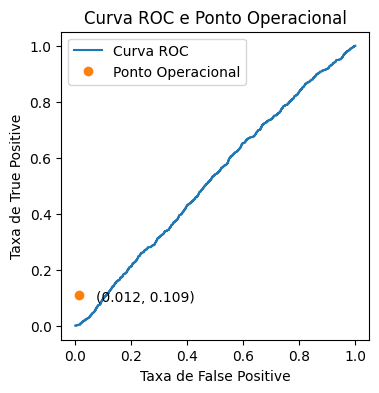

In [20]:
fpr, tpr, t = roc_curve(y2_muito_bom, lr_bin.decision_function(X_test))

p1 = CM_bom[0,1]/(CM_bom[0,1] + CM_bom[0,0])
p2 = CM_bom[1,1]/(CM_bom[1,1] + CM_bom[1,0])

# Mostrar resultados...
plt.figure(figsize=(4,4))

# Plot da Curva ROC
plt.plot(fpr,tpr, label='Curva ROC')

# Plot dos Pontos
plt.plot(p1, p2, 'o', label='Ponto Operacional')

plt.title('Curva ROC e Ponto Operacional')
plt.ylabel('Taxa de True Positive')
plt.xlabel('Taxa de False Positive')
plt.legend()
plt.text(p1+0.06, p2-0.02, '(' + str(np.round(p1,3)) + ', ' + str(np.round(p2,3)) + ')' )
plt.axis('scaled')
plt.show()

Com esta curva ROC, podemos ver que existe uma baixa taxa tanto de verdadeiros positivos como de falsos positivos, o que significa que não é um bom classificador.

# Classificação Multi-classe

Na classificação multi-classe é pretendido treinar e avaliar classificadores com três dados de treino diferentes: smell, taste e overall.

# Classificador 1: Regressão logistica

Como foi mencionado no classificador binário, irão ser utilizados os mesmos valores calculados para a avaliação binária com o propósito de poupar tempo de execução.

Contudo, para serem encontrados os melhores valores, o procedimento a efetuar seria o mesmo usado anteriormente, onde iriamos testar vários parâmetros diferentes para cada tipo de dados de treino, sendo esses dados o "smell", "taste" e "overall".

In [21]:
#mudamos o valor do max_iter para 5000 porque o valor anterior não era suficiente para convergir
#tambem foi adicionado o parametro multi_class='multinomial' para que o modelo possa ser usado com mais de 2 classes
lr_multiclass = LogisticRegression(penalty='l2', max_iter=5000, 
                                C=melhores_params_logistic_regression[0], 
                                tol=melhores_params_logistic_regression[2], multi_class='multinomial')

# Reviews com classificação overall

In [22]:
lr_multiclass.fit(X_train, y1Overall)
score_train_overall = round(lr_multiclass.score(X_train, y1Overall) * 100, 3)
score_test_overall = round(lr_multiclass.score(X_test, y2Overall) * 100, 3)

CM_overall = confusion_matrix(y2Overall, lr_multiclass.predict(X_test))
with open('logistic_overall_results.p', 'wb') as file:
    pickle.dump({'confusion_matrix': CM_overall, 'train_score': score_train_overall, 'test_score':score_test_overall}, file)

In [23]:
Logistic_overall_results = openFile('logistic_overall_results.p')

CM_overall = Logistic_overall_results['confusion_matrix']
score_train_overall = Logistic_overall_results['train_score']
score_test_overall = Logistic_overall_results['test_score']

print('Score classificação overall train: ', score_train_overall, '%')
print('Score classificação overall test: ', score_test_overall, '%')
print('Matriz de confusão das reviews overall: \n', CM_overall)

Score classificação overall train:  75.119 %
Score classificação overall test:  25.588 %
Matriz de confusão das reviews overall: 
 [[ 268  221  268  299   78   78   69   72   46]
 [ 111  143  368  431  119   56   33   12    2]
 [ 100  183  572 1090  335  257  115   33   14]
 [ 126  173  622 2130 1135  899  424  155   38]
 [  76   40  219 1038  864  893  562  223   62]
 [  94   37  134  701  684 1144  736  364  116]
 [  97   15   65  379  455  804  763  455  166]
 [  69   10   29  147  182  396  483  375  182]
 [  57    3   13   54   67  131  204  199  138]]


# Reviews com classificação smell

In [24]:
lr_multiclass.fit(X_train, y1Smell)
score_train_smell = round(lr_multiclass.score(X_train, y1Smell) * 100, 3)
score_test_smell = round(lr_multiclass.score(X_test, y2Smell) * 100, 3)

CM_smell = confusion_matrix(y2Smell, lr_multiclass.predict(X_test))
with open('logistic_smell_results.p', 'wb') as file:
    pickle.dump({'confusion_matrix': CM_smell, 'train_score': score_train_smell, 'test_score':score_test_smell}, file)

In [25]:
Logistic_smell_results = openFile('logistic_smell_results.p')

CM_smell = Logistic_smell_results['confusion_matrix']
score_train_smell = Logistic_smell_results['train_score']
score_test_smell = Logistic_smell_results['test_score']

print('Score classificação smell train: ', score_train_smell, '%')
print('Score classificação smell test: ', score_test_smell, '%')
print('Matriz de confusão das reviews smell: \n', CM_smell)

Score classificação smell train:  77.316 %
Score classificação smell test:  40.348 %
Matriz de confusão das reviews smell: 
 [[2114 1475  990  268   51]
 [ 974 1917 2317  655   75]
 [ 579 1630 3791 1863  260]
 [ 150  444 1799 1994  442]
 [  48   80  286  527  271]]


# Reviews com classificação taste

In [26]:
lr_multiclass.fit(X_train, y1Taste)
score_train_taste = round(lr_multiclass.score(X_train, y1Taste) * 100, 3)
score_test_taste = round(lr_multiclass.score(X_test, y2Taste) * 100, 3)

CM_taste = confusion_matrix(y2Taste, lr_multiclass.predict(X_test))
with open('logistic_taste_results.p', 'wb') as file:
    pickle.dump({'confusion_matrix': CM_taste, 'train_score': score_train_taste, 'test_score': score_test_taste}, file)

In [47]:
Logistic_taste_results = openFile('logistic_taste_results.p')

CM_taste = Logistic_taste_results['confusion_matrix']
score_train_taste = Logistic_taste_results['train_score']
score_test_taste = Logistic_taste_results['test_score']

print('Score classificação taste train: ', score_train_taste, '%')
print('Score classificação taste test: ', score_test_taste, '%')
print('Matriz de confusão das reviews taste: \n', CM_taste)

Score classificação taste train:  78.923 %
Score classificação taste test:  41.688 %
Matriz de confusão das reviews taste: 
 [[2172 1393  986  242   27]
 [ 931 1709 2096  592   68]
 [ 520 1518 3940 1971  231]
 [ 165  436 1894 2287  489]
 [  46   69  315  589  314]]


Ao analisar os resultados anteriores, podemos ver que os resultados das classificações não são bons. Algumas razões para este comportamento devem-se ao facto de poderem haver palavras repetidas em diferentes classificações, o que faz com que exista uma alta probabilidade de erro. Outras razões para este comportamento e analizando apenas as classificações taste e smell, existem também bastantes erros, visto que pode acontecer uma cerveja ter uma boa classificação overall mas ter uma classificação smell ou taste mais baixa. O mesmo pode acontecer ao contrário onde uma classificação com overall baixo pode ter uma classificação smell ou taste alta.

Para que a classificação fosse mais correta, teria de existir mais consistência nas classificação, ou seja, reviews com overall alto teriam de ter também classificações de smell e taste altos.

<a id='section7'/></a>
# Classificador 2: SVM - Support Vector Machine

As Máquinas de Suporte Vetorial (SVM) são algoritmos de aprendizagem supervisionada utilizados para problemas de classificação e regressão. No contexto da classificação, as SVM são classificadores binários, o que significa que são capazes de separar dados em duas classes.
m:

O objetivo principal das SVM é encontra linha dano de separação entre as classes de dados que maximize a margem, que é a distância eessa linhaplano e os pontos de dados mais próximos de cada classe (vetores de supouporte:

Os vetores de suporte são odospontos de dados mais pa linhaiperplano de seSo. Eles são cruciais para a definição da margem de decisão e, consequentemente, para a class ficação.
Apenas os vetores de suporte inauenciam na definição.oãTem como principais vantagens a boa performance em problemas de classificação e a eficácia para dados de grandes dimensões.dComo desvantagens podemos apontar a sensibilidade a
Sescalamento ensível a, assim como a necessidadeto dos dads ligeirosNecessidade de ajuste fino de parâmetros, incl A lém disso pndo a escolpior ha do kern a lidar com  um desempenho inferior em, como é o nosso caso grandes conjuntos de dados.

### Classificação Binária - Quais os melhores parâmetros?

In [48]:
#parametros 
cs = np.arange(1, 5, 0.5)
ps = ['l1', 'l2']

combinacoes = [(p, c) for p in ps for c in cs]
resultados_comb = []


for p, c in combinacoes:
    #print(p, c)
    lsvc = LinearSVC(dual=False, penalty=p, C=c, max_iter=5000, tol=1e-2)
    resultados_comb.append(np.mean(cross_val_score(lsvc, X_train, y1_muito_bom, cv=3)))

pickle.dump({'param': combinacoes, 'scores': resultados_comb}, open('resultados_comb_svc.p', 'wb'))

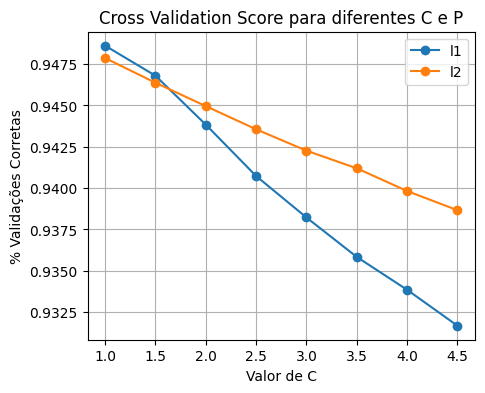

In [49]:
file = pickle.load(open('resultados_comb_svc.p', 'rb'))
combos_p_c = file["param"]
resultados_p_c = file["scores"]

# Valores de C testados (1 a 5)
cs = np.arange(1.0, 5.0, 0.5)

# Dividir resultados por penalidades
resultados_l1 = resultados_p_c[:len(cs)]
resultados_l2 = resultados_p_c[len(cs):]

plt.figure(figsize=(5, 4))
plt.plot(cs, resultados_l1, '-o')
plt.plot(cs, resultados_l2, '-o')
plt.title('Cross Validation Score para diferentes C e P')
plt.xlabel('Valor de C')
plt.ylabel('% Validações Corretas')
plt.legend(('l1', 'l2'))
plt.grid()
plt.show()

Observando a figura acima, verificamos que a convergência se inicia a partir do ponto em que C=1. Dado que l1 tem uma maior percenatgem de validações corretas para esse ponto, é essa penalidade que vamos usar.

Inicializamos então o classificador para ser utilizado nas classificações.

In [50]:
lsvc_bin = LinearSVC(dual=False, penalty='l1', C=1, max_iter=5000, tol=1e-2)

### Classificação binária das reviews muito boas

In [51]:
# SVM (LinearSVC)
score_train_bom = lsvc_bin.fit(X_train, y1_muito_bom)
score_train_bom = lsvc_bin.score(X_train, y1_muito_bom)
score_test_bom = lsvc_bin.score(X_test, y2_muito_bom)

# Resultados
print('Score treino binário bom: ', round(score_train_bom * 100, 3), '%')
print('Score teste binário bom: ', round(score_test_bom * 100, 3), '%')

CM_bom = confusion_matrix(y2_muito_bom, lsvc_bin.predict(X_test))
print('Matriz de confusão das reviews muito boas: \n', CM_bom)
print('Erros: ', CM_bom[0][1] + CM_bom[1][0])

Score treino binário bom:  95.24 %
Score teste binário bom:  96.492 %
Matriz de confusão das reviews muito boas: 
 [[24112    22]
 [  855    11]]
Erros:  877


### Classificação binária das reviews muito más

In [52]:
# SVM (LinearSVC)
score_train_mau = lsvc_bin.fit(X_train, y1_muito_mau)
score_train_mau = lsvc_bin.score(X_train, y1_muito_mau)
score_test_mau = lsvc_bin.score(X_test, y2_muito_mau)

# Resultados
print('Score treino binário mau: ', round(score_train_mau * 100, 3), '%')
print('Score teste binário mau: ', round(score_test_mau * 100, 3), '%')

CM_mau = confusion_matrix(y2_muito_mau, lsvc_bin.predict(X_test))
print('Matriz de confusão das reviews muito más: \n', CM_mau)
print('Erros: ', CM_mau[0][1] + CM_mau[1][0])

Score treino binário mau:  95.115 %
Score teste binário mau:  90.572 %
Matriz de confusão das reviews muito más: 
 [[22168   158]
 [ 2199   475]]
Erros:  2357


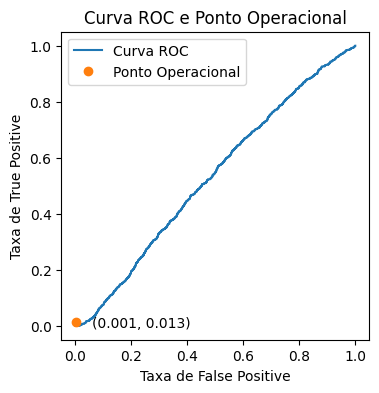

In [53]:
fpr, tpr, t = roc_curve(y2_muito_bom, lsvc_bin.decision_function(X_test))

p1 = CM_bom[0,1]/(CM_bom[0,1] + CM_bom[0,0])
p2 = CM_bom[1,1]/(CM_bom[1,1] + CM_bom[1,0])

# Mostrar resultados...
plt.figure(figsize=(4,4))

# Plot da Curva ROC
plt.plot(fpr,tpr, label='Curva ROC')

# Plot dos Pontos
plt.plot(p1, p2, 'o', label='Ponto Operacional')

plt.title('Curva ROC e Ponto Operacional')
plt.ylabel('Taxa de True Positive')
plt.xlabel('Taxa de False Positive')
plt.legend()
plt.text(p1+0.06, p2-0.02, '(' + str(np.round(p1,3)) + ', ' + str(np.round(p2,3)) + ')' )
plt.axis('scaled')
plt.show()


Com esta curva ROC, podemos ver que existe uma baixa taxa tanto de verdadeiros positivos como de falsos positivos, o que significa que à semelhança da regressão logística também não é um bom classificador.

### Classificação Multi-Classe

Tal como fizemos para a regressão logística, vamos voltar a usar os valores obtidos na classificação binária para a classificação multi-classe. Depois vamos efetuar a classificação separadamente para cada um dos atributos, tal como foi feito anteriormente.

In [54]:
# SVM (LinearSVC)
lsvc_multiclasse = LinearSVC(dual=False, penalty='l2', C=1, max_iter=5000, tol=1e-2)

# Reviews com classificação overall

In [55]:
lsvc_multiclasse.fit(X_train, y1Overall)
score_train_overall = round(lsvc_multiclasse.score(X_train, y1Overall) * 100, 3)
score_test_overall = round(lsvc_multiclasse.score(X_test, y2Overall) * 100, 3)

CM_overall = confusion_matrix(y2Overall, lsvc_multiclasse.predict(X_test))
with open('svc_overall_results.p', 'wb') as file:
    pickle.dump({'confusion_matrix': CM_overall, 'train_score': score_train_overall, 'test_score': score_test_overall}, file)

In [56]:
svc_overall_results = openFile('svc_overall_results.p')

CM_overall = svc_overall_results['confusion_matrix']
score_train_overall = svc_overall_results['train_score']
score_test_overall = svc_overall_results['test_score']

print('Score classificação overall train: ', score_train_overall, '%')
print('Score classificação overall test: ', score_test_overall, '%')
print('Matriz de confusão das reviews overall: \n', CM_overall)

Score classificação overall train:  63.495 %
Score classificação overall test:  27.116 %
Matriz de confusão das reviews overall: 
 [[ 304  110  253  381   75   84   77   72   43]
 [  96   80  286  620   90   56   34   11    2]
 [  78   97  405 1460  267  237  111   34   10]
 [  86   79  417 2707  934  932  393  123   31]
 [  50   24  142 1265  747  954  581  176   38]
 [  62   17   93  828  619 1242  739  329   81]
 [  54    5   59  462  374  874  814  441  116]
 [  35    5   24  184  160  410  576  367  112]
 [  38    0   14   67   55  149  217  213  113]]


# Reviews com classificação smell

In [57]:
lsvc_multiclasse.fit(X_train, y1Smell)
score_train_smell = round(lsvc_multiclasse.score(X_train, y1Smell) * 100, 3)
score_test_smell = round(lsvc_multiclasse.score(X_test, y2Smell) * 100, 3)

CM_smell = confusion_matrix(y2Smell, lsvc_multiclasse.predict(X_test))
with open('svc_smell_results.p', 'wb') as file:
    pickle.dump({'confusion_matrix': CM_smell, 'train_score': score_train_smell, 'test_score': score_test_smell}, file)

In [58]:
svc_smell_results = openFile('svc_smell_results.p')

CM_smell = svc_smell_results['confusion_matrix']
score_train_smell = svc_smell_results['train_score']
score_test_smell = svc_smell_results['test_score']

print('Score classificação smell train: ', score_train_smell, '%')
print('Score classificação smell test: ', score_test_smell, '%')
print('Matriz de confusão das reviews smell: \n', CM_smell)

Score classificação smell train:  68.623 %
Score classificação smell test:  42.776 %
Matriz de confusão das reviews smell: 
 [[2291 1227 1140  212   28]
 [ 902 1672 2700  616   48]
 [ 454 1248 4414 1859  148]
 [ 128  317 2010 2123  251]
 [  46   54  310  608  194]]


# Reviews com classificação taste

In [62]:
lsvc_multiclasse.fit(X_train, y1Taste)
score_train_taste = round(lsvc_multiclasse.score(X_train, y1Taste) * 100, 3)
score_test_taste = round(lsvc_multiclasse.score(X_test, y2Taste) * 100, 3)

CM_taste = confusion_matrix(y2Taste, lsvc_multiclasse.predict(X_test))
with open('svc_taste_results.p', 'wb') as file:
    pickle.dump({'confusion_matrix': CM_taste, 'train_score': score_train_taste, 'test_score': score_test_taste}, file)

In [63]:
svc_taste_results = openFile('svc_taste_results.p')

CM_taste = svc_taste_results['confusion_matrix']
score_train_taste = svc_taste_results['train_score']
score_test_taste = svc_taste_results['test_score']

print('Score classificação taste train: ', score_train_taste, '%')
print('Score classificação taste test: ', score_test_taste, '%')
print('Matriz de confusão das reviews taste: \n', CM_taste)

Score classificação taste train:  68.881 %
Score classificação taste test:  44.296 %
Matriz de confusão das reviews taste: 
 [[2387 1131 1053  229   20]
 [ 863 1388 2510  599   36]
 [ 431 1069 4573 1976  131]
 [ 145  272 2055 2494  305]
 [  53   46  323  679  232]]


Observando os resultados, verificamos que este classificador obtém resultados piores para os dados de treino do que o classificador para a regressão logística. Para os dados de teste, os resultados continuam a estar muito longe do ideal e não variam muito em relação aos que foram obtidos pela regressão logística.

<a id='section8'/></a>
# Classificador 3: Multinomial Naive Bayes

O algoritmo Multinomial Naive Bayes é um método de aprendizagem probabilística que é usado em Processamento de linguagem natural.

Este algoritmo é baseado no teorema de Bayes, que calcula a probabilidade de um evento ocorrer com base no conhecimento prévio das condições relacionadas a um evento e prevê a etiqueta de um texto. O Multinomial Naive Bayes calcula a probabilidade de cada etiqueta para um conjunto de dados e forncece a etiqueta com a maior probabilidade como saída.

As vantagens deste classificador é a sua facilidade de implementação uma vez que apenas é necessário calcular a probabilidade das etiquetas como foi mencionado anteriormente. Também é escalável o que significa que lida bem com conjuntos muito grandes de dados. Porém existem também desvantagens como com todos os classificadores sendo uma desvantagem a sua precisão de previsão mais baixa em comparação a outros classificadores.

### Classificação Binária

Para este classificador apenas será feita a classificação binária. Para tal, iremos usar os mesmos valores de y usados nas classificações binárias anteriores (y1_muito_bom, y1_muito_mau, y2_muito_bom, y2_muito_mau)

Tal como aconteceu nos classificadores anteriores, vamos começar por procurar os melhores parâmetros. Neste tipo de classificador apenas existem três parâmetros para serem testados, o parâmetro alpha que é um parâmetro de suavização, o parâmetro force_alpha e o parâmetro fit_prior.

In [41]:
alpha = [0.0001, 0.001, 0.1, 0.1, 0.5, 1]
force_alpha = [True, False]
fit_prior = [True, False]

param_combinations = product(alpha, force_alpha, fit_prior)

melhores_vals = 0
melhores_params = []

for alpha, force_alpha, fit_prior in param_combinations:
    nb = MultinomialNB(alpha=alpha, force_alpha=force_alpha, fit_prior=fit_prior)
    nb.fit(X_train, y1_muito_bom)
    testing_score = nb.score(X_train, y1_muito_bom)
    if testing_score > melhores_vals:
        melhores_vals = testing_score
        melhores_params = [alpha, force_alpha, fit_prior]

dump_to_pickle(melhores_vals, 'melhores_vals_MultinomialNB.p')
dump_to_pickle(melhores_params, 'melhores_params_MultinomialNB.p')

In [42]:
melhores_params_MultinomialNB = openFile('melhores_params_MultinomialNB.p')
melhores_vals_MultinomialNB = openFile('melhores_vals_MultinomialNB.p')

print("Melhores parâmetros encontrados no teste anterior: Alpha: ", melhores_params_MultinomialNB[0] 
      ,", force_alpha: ", melhores_params_MultinomialNB[1] , " e fit_prior: ", melhores_params_MultinomialNB[2])

print('Score de treino: ', round(melhores_vals_MultinomialNB*100, 3), '%')

Melhores parâmetros encontrados no teste anterior: Alpha:  0.0001 , force_alpha:  True  e fit_prior:  True
Score de treino:  96.159 %


Inicializamos então o classificador para ser utilizado nas classificações binárias.

In [43]:
nb_classifier = MultinomialNB(alpha=melhores_params_MultinomialNB[0], 
                              force_alpha=melhores_params_MultinomialNB[1], fit_prior=melhores_params_MultinomialNB[2])

### Classificação binária das reviews muito boas

In [44]:
nb_classifier.fit(X_train, y1_muito_bom)
score_train_bom = nb_classifier.score(X_train, y1_muito_bom)
score_test_bom = nb_classifier.score(X_test, y2_muito_bom)

print('Score treino binário bom: ', round(score_train_bom * 100, 3), '%')
print('Score teste binário bom: ', round(score_test_bom * 100, 3), '%')

CM_bom = confusion_matrix(y2_muito_bom, nb_classifier.predict(X_test))
print('Matriz de confusão das reviews muito boas: \n', CM_bom)
print('Erros: ', CM_bom[0][1] + CM_bom[1][0])

Score treino binário bom:  96.159 %
Score teste binário bom:  96.408 %
Matriz de confusão das reviews muito boas: 
 [[24097    37]
 [  861     5]]
Erros:  898


### Classificação binária das reviews muito más

In [45]:
nb_classifier.fit(X_train, y1_muito_mau)
score_train_mau = nb_classifier.score(X_train, y1_muito_mau)
score_test_mau = nb_classifier.score(X_test, y2_muito_mau)

print('Score treino binário bom: ', round(score_train_mau * 100, 3), '%')
print('Score teste binário bom: ', round(score_test_mau * 100, 3), '%')

CM_mau = confusion_matrix(y2_muito_mau, nb_classifier.predict(X_test))
print('Matriz de confusão das reviews muito boas: \n', CM_mau)
print('Erros: ', CM_mau[0][1] + CM_mau[1][0])

Score treino binário bom:  95.992 %
Score teste binário bom:  89.264 %
Matriz de confusão das reviews muito boas: 
 [[22164   162]
 [ 2522   152]]
Erros:  2684


Podemos verificar que nos testes binários com o classificador multinomial naive bayes, temos uns bons resultados de treino, descendo um pouco para os dados de teste. Uma possível explicação para os erros é a probabilidade de algumas palavras existirem tanto em reviews com overall alto como baixo.

<a id='section9'/></a>
# Comparação de resultados

### Comparação binária

Ao compararmos os resultados obtidos, podemos averiguar que a regressão logistica é o classificador com um score de teste e treino em ambos os casos mais elevado. Podemos então afirmar que, para etse tipo de dados, a regressão logistica será a mais correta a usar, mesmo demorando um pouco mais a executar a mesma.

### Comparação multi-classe

Neste caso, existe uma classificação claramente superior para a classificação dos dados de treino sendo essa classificação a regressão logistica novamente. Contudo para a classificação dos dados de teste, os resultados foram muito pouco satisfatórios tanto no classificador de regressão logistica como no classificador SVM (Support Vector Machine). Posto isto, o classificador mais correto de utilizar seria o classificador de regressão logistica visto que o score obtido com os dados de treino foi superior aos obtidos com o classificador SVM.